# Dog Breed Classification Using Transfer Learning

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

## DOWNLAD & INSTALL REQUIRED DEPENDENCIES

In [1]:
# Install smdebug
!pip install smdebug

In [2]:
!pip install cloudpathlib
!pip install torch
!pip install torchvision

     |████████████████████████████████| 52 kB 2.4 MB/s             
     |████████████████████████████████| 881.9 MB 5.2 kB/s                |█████████████████▉              | 493.0 MB 101.5 MB/s eta 0:00:04
     |████████████████████████████████| 23.3 MB 21.1 MB/s            
     |████████████████████████████████| 881.9 MB 6.6 kB/s              
  Attempting uninstall: torch
    Found existing installation: torch 1.10.2
    Uninstalling torch-1.10.2:
      Successfully uninstalled torch-1.10.2


In [3]:
# Import packages
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel

from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor



import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import smdebug
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
# from markupsafe import Markup


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import IPython

import numpy as np
import boto3
from cloudpathlib import CloudPath

from PIL import Image
from io import BytesIO


[2022-05-01 12:42:21.288 ip-172-16-164-131:32504 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## FETCH & UPLOAD THE DATASET TO AWS S3

## Dataset
The dog breed classification dataset provided by Udacity has been used here. The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

In [ ]:
# Command to download and unzip data

#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip -d dataset/

In [8]:
#!ls /root/'Deep Learning Project'/dataset

dogImages  dogImages.zip


In [10]:
#!aws s3 cp /root/'Deep Learning Project'/dataset s3://image-classification-dog-breed --recursive

upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg
upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenp

## HYPERPARAMETER TUNING


In this part a resnet18 pretrained model has been used to perform hyperparameter tuning - such that it the best hyperparameters are determined for the predictor model. 
The hyperparameters being tuned are:

1) Learning rate    --> Continuous parameter with values tuned between 0.001 and 0,1

2) Batch size       --> Categorical parameter with specific list of trial values

3) Number of epochs --> Integer parameter between 1 and 2(inclusive)

The training and testing script in `hpo.py` is used to perform hyperparameter tuning.

In [4]:
# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([8, 16, 32, 64, 128]),
    "epochs": IntegerParameter(1, 5)
}

# The objective metric to be used by the Hyperparameter Tuning jobs is the Test Accuracy of the model on the validation dataset

objective_metric_name = "Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Accuracy", "Regex": "Test set: Accuracy: ([0-9\\.]+)%"}]


In [13]:
# Create estimators for HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=sagemaker.get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge"
)

# Configuring the estimated to run 6 total hyperparameter tuner jobs with a allowed parallel job count of 2

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [ ]:

inputs_train = 's3://image-classification-dog-breed/dogImages/train/'
inputs_test = 's3://image-classification-dog-breed/dogImages/valid/'

tuner.fit({"training": inputs_train,"test":inputs_test})


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [15]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-05-01 14:05:11 Starting - Preparing the instances for training
2022-05-01 14:05:11 Downloading - Downloading input data
2022-05-01 14:05:11 Training - Training image download completed. Training in progress.
2022-05-01 14:05:11 Uploading - Uploading generated training model
2022-05-01 14:05:11 Completed - Training job completed


{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '"16"',
 'epochs': '5',
 'lr': '0.05074174354103056',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-05-01-13-14-27-277"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-05-01-13-14-27-277/source/sourcedir.tar.gz"'}

In [17]:
tuner.best_training_job()

'pytorch-training-220501-1314-004-9fd5b1ad'

## Model Profiling and Debugging

Using the best hyperparameters, create and finetune a new model

Using the `train_model.py` script to perform model profiling and debugging.

Using the attach method of the HyperparameterTuner class to retrieve the job details(as I had taken a pause and shutdown the notebook after the tuning job ran)

In [19]:
attach_tuner = HyperparameterTuner.attach("pytorch-training-220501-1314")

In [20]:
attach_tuner.best_estimator().hyperparameters()


2022-05-01 14:05:11 Starting - Preparing the instances for training
2022-05-01 14:05:11 Downloading - Downloading input data
2022-05-01 14:05:11 Training - Training image download completed. Training in progress.
2022-05-01 14:05:11 Uploading - Uploading generated training model
2022-05-01 14:05:11 Completed - Training job completed


{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '"16"',
 'epochs': '5',
 'lr': '0.05074174354103056',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-05-01-13-14-27-277"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-05-01-13-14-27-277/source/sourcedir.tar.gz"'}

In [ ]:
The optimum hyperparameters being determined by the tuning job are:

1) Learning rate    --> 0.05074174354103056

2) Batch size       --> 16

3) Number of epochs --> 5

In [21]:
# Debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"include_regex": "CrossEntropyLoss_output_0","train.save_interval": "100", "eval.save_interval": "10"}
)

In [22]:
debugger_config.hook_parameters

{'include_regex': 'CrossEntropyLoss_output_0',
 'train.save_interval': '100',
 'eval.save_interval': '10'}

In [23]:
hyperparameters = attach_tuner.best_estimator().hyperparameters()


2022-05-01 14:05:11 Starting - Preparing the instances for training
2022-05-01 14:05:11 Downloading - Downloading input data
2022-05-01 14:05:11 Training - Training image download completed. Training in progress.
2022-05-01 14:05:11 Uploading - Uploading generated training model
2022-05-01 14:05:11 Completed - Training job completed


-----------------------------------------------------------------------------------------------------
#### The best hyperparameters json retrieved from the tuning job contains the batch_size as a string.
#### The PyTorch estimator expects the batch-size in an integer variable.

#### Stripping the quotes on batch-size value for compatibility with PyTorch

In [24]:
hyperparameters['batch-size']

'"16"'

In [26]:
hyperparameters['batch-size']=hyperparameters['batch-size'].replace("\"", '')
hyperparameters

{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '16',
 'epochs': '5',
 'lr': '0.05074174354103056',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-05-01-13-14-27-277"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-05-01-13-14-27-277/source/sourcedir.tar.gz"'}

In [28]:
# Create and fit an estimator

estimator_debug = PyTorch(
    entry_point="train_model.py",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [32]:
inputs_train = 's3://image-classification-dog-breed/dogImages/train/'
inputs_test = 's3://image-classification-dog-breed/dogImages/valid/'

estimator_debug.fit({"training": inputs_train,"test":inputs_test}, wait=True)

2022-05-01 15:12:35 Starting - Starting the training job...
2022-05-01 15:13:01 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
............
2022-05-01 15:15:06 Downloading - Downloading input data.........
2022-05-01 15:16:27 Training - Downloading the training image.....................
2022-05-01 15:20:09 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-01 15:20:08,549 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-05-01 15:20:08,572 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-01 15:20:08,585 sagemaker_pytorch_container.training INFO     Invoking user 

In [33]:
# Print the name of the latest training job for the PyTorch estimator

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator_debug.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2022-05-01-15-12-35-503
Region: us-east-1


In [34]:
estimator_debug.latest_job_debugger_artifacts_path()

's3://sagemaker-us-east-1-700919767769/pytorch-training-2022-05-01-15-12-35-503/debug-output'

-----------------------------------------------------------------------------------------------------
### Plotting the debugging output.


In [35]:
trial = create_trial(estimator_debug.latest_job_debugger_artifacts_path())

trial.tensor_names()


[2022-05-01 15:29:57.572 ip-172-16-164-131:32504 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-05-01-15-12-35-503/debug-output


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


[2022-05-01 15:29:58.989 ip-172-16-164-131:32504 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-05-01 15:30:00.012 ip-172-16-164-131:32504 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [36]:
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))


21
9


In [38]:
# Helper methods to plot the captured debugging output

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


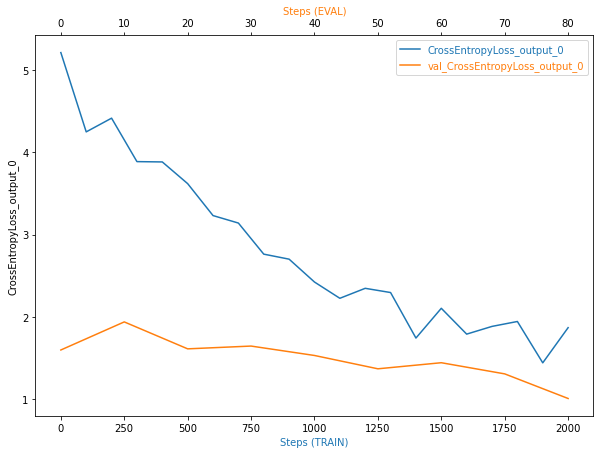

In [39]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

# change lingo
A strange behaviour was observed with the debugger output during the preparations runs. For these runs, I set the number of epochs to 1 (one) in order to reduce AWS instance costs. Initially, the output had a length of 1 (one) and its value was 0 (zero). That means that the hook save_intervals configuration was too big to properly observe and capture the tensors being generated by the training script. This was corrected by the reduction of the save_intervals and increase of epochs.

In [40]:
# Display the profiler output
tj = TrainingJob(training_job_name, region)

# Check if profiler processing is complete and reports are available
tj.wait_for_sys_profiling_data_to_be_available()


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-700919767769/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-05-01-15-12-35-503/profiler-output


Profiler data from system is available


In [41]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

In [42]:
view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-05-01 15:30:50.673 ip-172-16-164-131:32504 INFO metrics_reader_base.py:134] Getting 16 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [43]:
rule_output_path = estimator_debug.output_path + estimator_debug.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-05-01-15-12-35-503/rule-output


In [44]:
# Download the profiler report output

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2022-05-01 15:29:23     439295 pytorch-training-2022-05-01-15-12-35-503/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-05-01 15:29:22     298599 pytorch-training-2022-05-01-15-12-35-503/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-05-01 15:29:17        550 pytorch-training-2022-05-01-15-12-35-503/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-05-01 15:29:17      44489 pytorch-training-2022-05-01-15-12-35-503/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-05-01 15:29:17       2018 pytorch-training-2022-05-01-15-12-35-503/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-05-01 15:29:17        130 pytorch-training-2022-05-01-15-12-35-503/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-05-01 15:29:17      15019 pytorch-training-2022-05-01-15-12-35-503/rule-output/ProfilerReport/profiler-output/profiler-re

In [45]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator_debug.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [46]:
profiler_report_name

'ProfilerReport'

In [47]:


IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [48]:
estimator_debug.latest_training_job.job_name

'pytorch-training-2022-05-01-15-12-35-503'

In [49]:
sagemaker_session = sagemaker.session.Session()
sagemaker_session.default_bucket() 

'sagemaker-us-east-1-700919767769'

In [50]:
estimator_debug

------------------------------------------------------------------------------------------------------------------------

## Model Deploying

In [51]:
# Deploy your model to an endpoint

jpeg_serializer = IdentitySerializer("image/jpeg")
json_deserializer = JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        

In [56]:


sagemaker_session = sagemaker.session.Session()
latest_job = 'pytorch-training-2022-05-01-15-12-35-503'
model = PyTorchModel(model_data = 's3://' + sagemaker_session.default_bucket() +"/"+ latest_job + '/output/model.tar.gz',
                     role = sagemaker.get_execution_role(),
                     framework_version = '1.8',
                     source_dir="code",
                     entry_point = 'pretrained_model.py',
                     py_version='py3',
                     predictor_cls=ImagePredictor)


In [57]:
predictor=model.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") 


------!

In [58]:
predictor.endpoint_name

'pytorch-inference-2022-05-01-15-52-31-923'

In [37]:
# Download the validation folder from dataset

cp = CloudPath("s3://image-classification-dog-breed/dogImages/valid")
cp.download_to("valid")

PosixPath('valid')

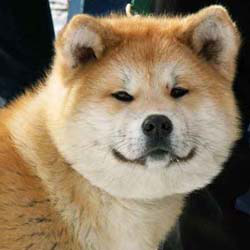

In [110]:
import io
image_bytes = open('valid/004.Akita/Akita_00227.jpg', 'rb').read()

Image.open(io.BytesIO(image_bytes))

In [108]:
# Actual label for an image 

target_str = 'valid/'
in_pos = 'valid/004.Akita/Akita_00227.jpg'.index(target_str) + len(target_str)
label = int('valid/004.Akita/Akita_00227.jpg'[in_pos:in_pos+3])
label

4

In [107]:
# Predicted label for an image 

image_bytes = open('valid/004.Akita/Akita_00227.jpg', 'rb').read()

response = predictor.predict(image_bytes, initial_args={'ContentType':'image/jpeg'})

prediction = np.argmax(response[0]) + 1  
prediction

9

### The predicted label is different from the expected correct label for the Akita breed image

Incorrect testing prediction can be because of insufficient training.

To confirm the reason, will run a prediction with a training set image.

In [60]:
image_bytes = open('train/057.Dalmatian/Dalmatian_04005.jpg', 'rb').read()

response = predictor.predict(image_bytes, initial_args={'ContentType':'image/jpeg'})

prediction = np.argmax(response[0]) + 1  
prediction

124

### The training set image prediction is also incorrect. Expected 57 but model predicted 124

Incorrect training prediction means the issue is with the complexity of the model.
The model needs to handle more complexity to make the correct predictions

In [118]:
# Shutdown/delete your endpoint to stop incurring charges
predictor.delete_endpoint()

In [119]:
's3://' + sagemaker_session.default_bucket() +"/"+ latest_job + '/output/model.tar.gz'

's3://sagemaker-us-east-1-700919767769/pytorch-training-2022-05-01-15-12-35-503/output/model.tar.gz'